<a href="https://colab.research.google.com/github/DrSewe/Breast_Cancer_Image_Processing_-_CNN/blob/main/Breast_Cancer_Image_Processing_%7C_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-ultrasound-images-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1209633%2F2021025%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240307%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240307T060453Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D18109df5bc032bb73525db500bea616dfad675ff23ebf60762fcdf3c3469a0895df60f7316423a2902d7caab6b6bb889c4529886673ff17eae8c657e2ddf4b9388681e6702a1c3a0a70a22dff0b148627ab2859f87baf4fbffbe7128aae1060489a58dc5f04a026509b988ba467da53cfa338a997b8ca39cac9cd7155eee278059ebb94dd1246a8fcfd8051676d6e0080c1e72ee95614e3588f1d378590fe056910807293b2f85161c8bdcfdd187e636737660a0f22e66ae5d8f7dbcbf87387e9ca9ef3e30920a0cc00c9b00cba4c184a14247e983c2b9810742140c1116be6b4a018d77f88da3bcdaa4db9d90e90b4d60ab4ca37dc2888fe01f48e925023c3b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 204421470 bytes downloaded
Downloaded and uncompressed: breast-ultrasound-images-dataset
Data source import complete.


# Data İmportation

**İmporting basic libraries**

In [ ]:
import tensorflow as tf
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import random

**Defining the path**

In [ ]:
path = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
data_dir = pathlib.Path(path)

**Getting class names**

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['benign', 'malignant', 'normal'], dtype='<U9')

**Define paths and image count**

In [ ]:
benignPath = os.path.join(data_dir,'bening')
malignantPath = os.path.join(data_dir,'malignant')
normalPath = os.path.join(data_dir,'normal')

**İmage count**

In [ ]:
imageCount = len(list(data_dir.glob('*/*.png')))
imageCount

1578

# Make Plotting of Random İmages

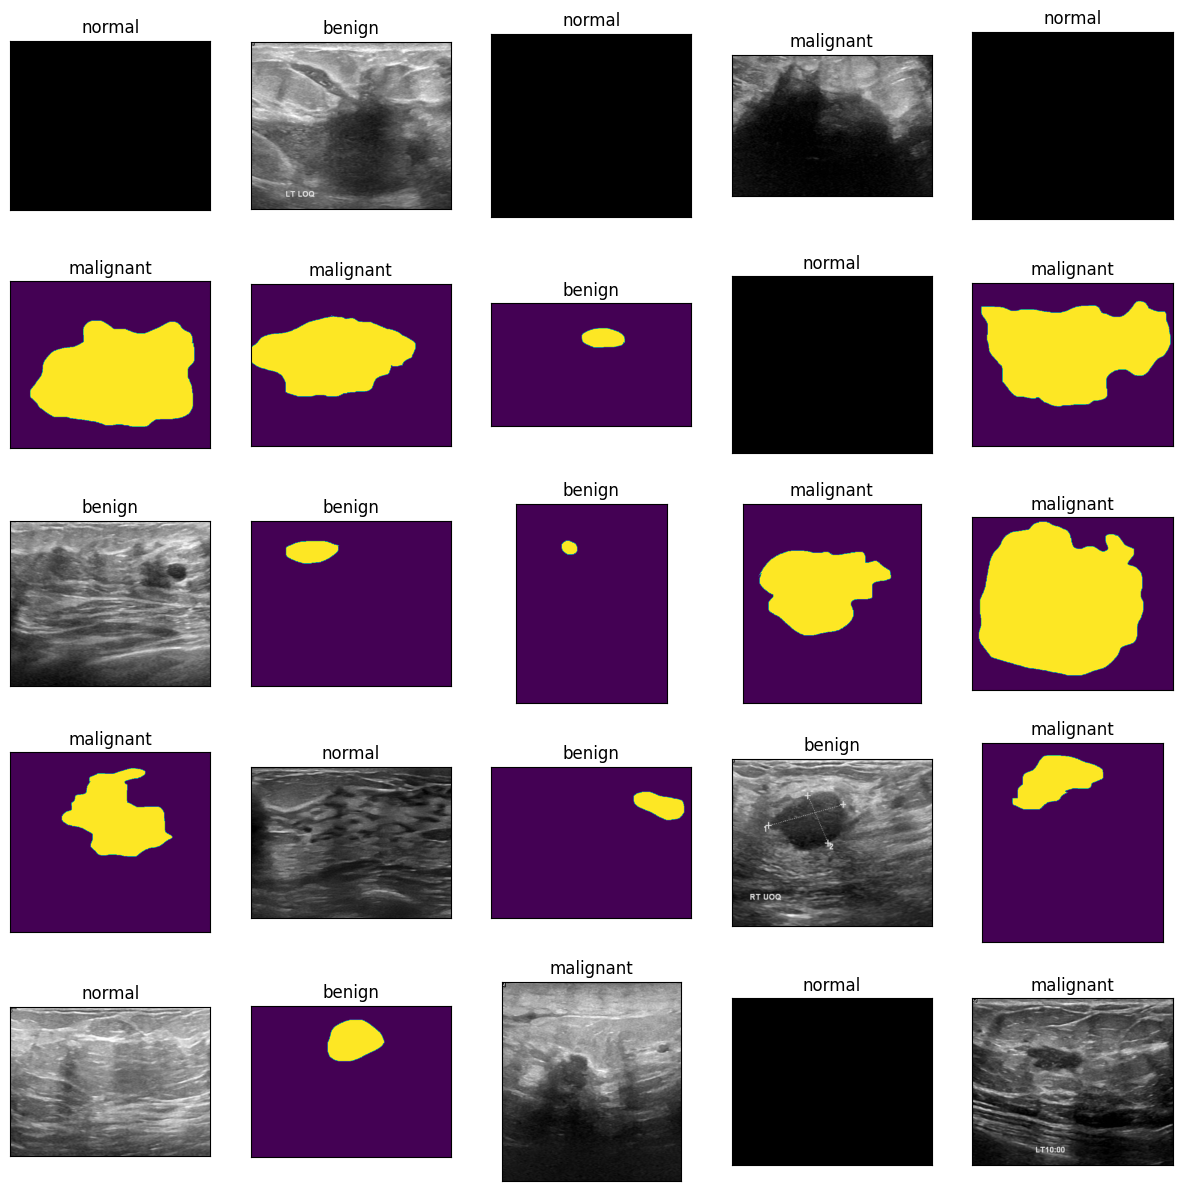

In [ ]:
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    random_class = random.choice(class_names)
    img = plt.imread(random.choice(list(data_dir.glob(random_class+"/*.png"))))
    plt.xticks([])
    plt.yticks([])
    plt.title(random_class)
    plt.imshow(img)

**Check the image formats**

In [ ]:
from pathlib import Path
import imghdr

data_dir = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

# Build the CNN

In [ ]:
batch_size = 200
img_height = 224
img_width = 224

**Separating data sets**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(
                  data_dir,
                  validation_split=0.2,
                  subset="training",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)


val_data = image_dataset_from_directory(data_dir,
                                        validation_split=0.2,
                                        subset="validation",
                                        seed=123,
                                        image_size=(img_height,img_width),
                                        batch_size=batch_size)

Found 1578 files belonging to 3 classes.
Using 1263 files for training.
Found 1578 files belonging to 3 classes.
Using 315 files for validation.


# Define the Model

In [ ]:
from tensorflow.keras import layers
model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3,activation="softmax")
])

# Compile the Model

In [ ]:
model.compile(optimizer="Adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"])

**Use GPU to fit the model else it will take much more time**

In [ ]:
epochs = 10
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data,
                    batch_size=batch_size)

Epoch 1/10
7/7 [==============================] - 56s 7s/step - loss: 2.7385 - accuracy: 0.4125 - val_loss: 1.0788 - val_accuracy: 0.2603
Epoch 2/10
7/7 [==============================] - 50s 7s/step - loss: 1.0425 - accuracy: 0.5075 - val_loss: 1.0632 - val_accuracy: 0.5587
Epoch 3/10
7/7 [==============================] - 48s 6s/step - loss: 0.9219 - accuracy: 0.5724 - val_loss: 0.8791 - val_accuracy: 0.5714
Epoch 4/10
7/7 [==============================] - 49s 6s/step - loss: 0.8377 - accuracy: 0.5907 - val_loss: 0.8241 - val_accuracy: 0.5937
Epoch 5/10
7/7 [==============================] - 48s 6s/step - loss: 0.7695 - accuracy: 0.6152 - val_loss: 0.7958 - val_accuracy: 0.6000
Epoch 6/10
7/7 [==============================] - 48s 6s/step - loss: 0.7017 - accuracy: 0.6295 - val_loss: 0.7980 - val_accuracy: 0.5778
Epoch 7/10
7/7 [==============================] - 44s 6s/step - loss: 0.6409 - accuracy: 0.6857 - val_loss: 0.7564 - val_accuracy: 0.7111
Epoch 8/10
7/7 [==================

**Keys**

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Accuracy vs Lost

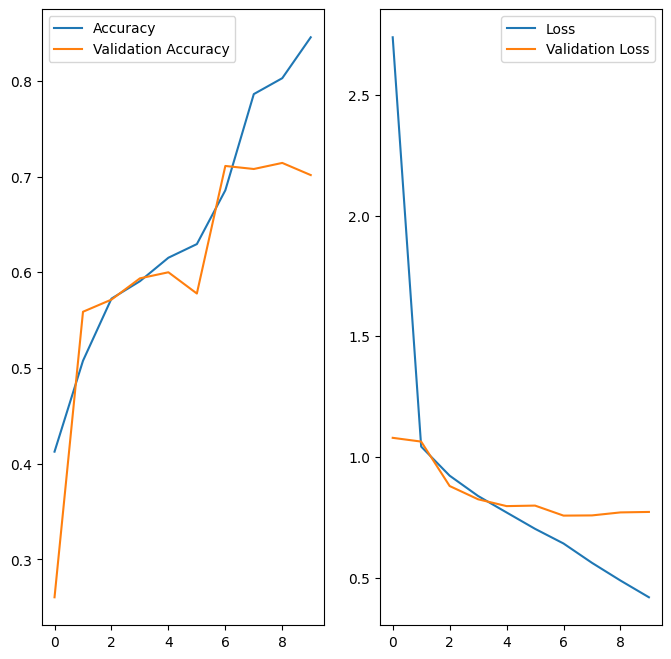

In [ ]:
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

**Evaluating - İt return the lost and accuracy**

In [ ]:
model.evaluate(val_data)

10/10 [==============================] - 3s 259ms/step - loss: 0.7333 - accuracy: 0.7048


[0.73325115442276, 0.7047619223594666]

**Model summary**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

# Predictions

1/1 [==============================] - 0s 30ms/step


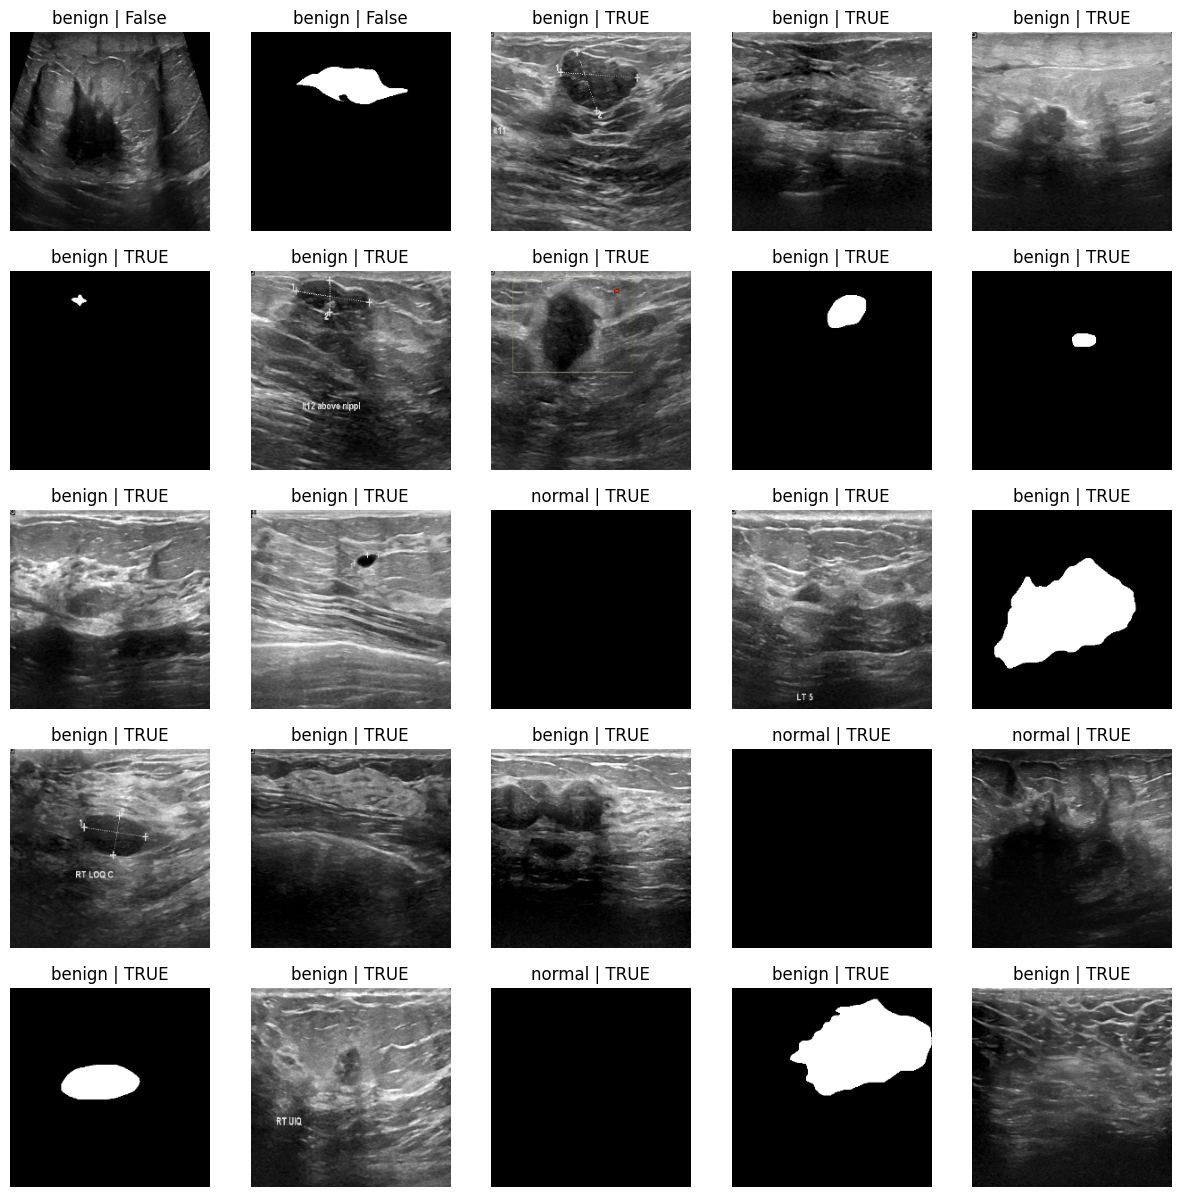

In [ ]:
plt.figure(figsize=(15, 15))
class_names = val_data.class_names
result = ' | False'
for images, labels in val_data.take(1):
    for i in range(25):

        ax = plt.subplot(5, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)

        predictions = model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicted_class]+result  )
        plt.axis("off")